In [25]:
import numpy as np
import matplotlib.pyplot as plt

from dask.distributed import Client
from dask_cuda import LocalCUDACluster

from ase.build import bulk
from abtem import FrozenPhonons, SMatrix, Potential, GridScan, AnnularDetector

import os
os.environ["MKL_NUM_THREADS"] = "1"

from abtem import config
config.set({'device': 'gpu'})
config.set({'lazy': True})

In [110]:
cluster = LocalCUDACluster(memory_limit='4gb')
client = Client(cluster)

C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51485 instead
  warnings.warn(
C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\dask_cuda\utils.py:168: UserWarning: Cannot get CPU affinity for device with index 0, setting default affinity
  warnings.warn(


In [26]:
cluster = LocalCUDACluster(memory_limit='10gb', n_workers=1)
client = Client(cluster)

C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 65274 instead
  warnings.warn(


In [27]:
atoms = bulk('Si', 'diamond', a=5.43, cubic=True)
atoms *= (6, 6, 6)

In [106]:
# number of plane waves in each chunk
plane_wave_chunks = 100

# Partioning of the griscan. The scattering matrix will be reduced in similarly partitioned chunks. 
# Should be equal to or greater than the interpolation.
scan_partitions = (6, 6)

# Number of positions per reduction operation (single call to np.tensordot), 
# A large value reduces the number of required iterations in Python, but also increases the total number of FLOPS required
positions_per_reduction = 500

# Maximum number of scattering matrices in memory at any point
max_concurrent_s_matrices = 1

frozen_phonons = FrozenPhonons(atoms, 6, {'Si': .1})

potential = Potential(frozen_phonons, 
                      gpts=1024,
                      projection='infinite', 
                      slice_thickness=.5)

probe = SMatrix(energy=200e3, semiangle_cutoff=20, chunks=plane_wave_chunks, interpolation=6, max_concurrent=max_concurrent_s_matrices)

scan = GridScan()

detectors = AnnularDetector(50, 150, ensemble_mean=False)
#detectors = AnnularDetector(0, 15, ensemble_mean=False)

measurement = probe.scan(scan, 
                         detectors, 
                         potential,
                         scan_partitions=scan_partitions, 
                         positions_per_reduction=positions_per_reduction)

In [12]:
#measurement.visualize_graph()

In [107]:
probe.build().array

dask.array<from-value, shape=(61, 1024, 1024), dtype=complex64, chunksize=(61, 1024, 1024), chunktype=cupy.ndarray>

In [108]:
%%time
measurement.compute(scheduler='single-threaded')

[########################################] | 100% Completed | 12.0s
Wall time: 12 s


(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x1e22f135b80>)

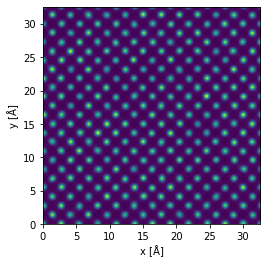

In [109]:
measurement.interpolate(.1).show()